<h1 class='font-effect-3d' style='font-family:Akronim; color:#66FF66;'>Styling, Links, Helpful Functions, & Code Modules</h1>
[`R interface to Keras`](https://tensorflow.rstudio.com/keras/) & [`Package Keras`](https://cran.r-project.org/web/packages/keras/keras.pdf) & [`Deep Learning with R`](https://github.com/jjallaire/deep-learning-with-r-notebooks)

[Full Version. Python](https://olgabelitskaya.github.io/kaggle_digits.html) & [Full Version. R](https://olgabelitskaya.github.io/kaggle_digits_R.html)</h4>

In [1]:
library(IRdisplay); library(repr)
library(tensorflow); library(keras)
library(imager); library(R6)
keras_backend<-backend()

Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:IRdisplay’:

    display

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image



In [2]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d|fire-animation');
body {background-color:#AAF0D1;} 
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:#FF9966;} 
div.input_prompt {color:#66FF66;} 
div.output_area pre,div.output_subarea {font-size:15px; color:#FF9966;}
div.output_stderr pre {background-color:#AAF0D1;} 
</style>")

<h1 class='font-effect-3d' style='font-family:Akronim; color:#66FF66;'>Data</h1>

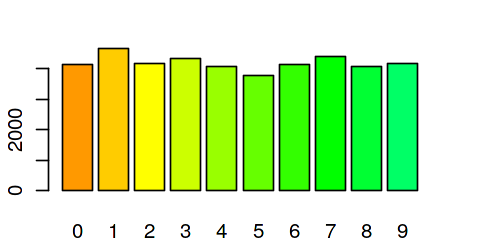

In [3]:
df_train<-read.csv("../input/train.csv")
df_test <-read.csv("../input/test.csv")
fw<-"best_digits.h5"
options(repr.plot.width=4,repr.plot.height=2)
par(mar=c(2,2,2,2))
df_train[,1] %>% 
    table() %>% 
    barplot(col=rainbow(10,start=.1,end=.4))

In [4]:
n<-nrow(df_train)
df_train<-df_train[sample(n),]
train_labels<-keras::to_categorical(as.matrix(df_train[,1]),
                                    num_classes=10)
train_images<-as.matrix(df_train[,-1])/255
test_images<-as.matrix(df_test)/255
c(dim(train_images),dim(test_images),dim(train_labels))

[1] 42000   784 28000   784 42000    10

[1] 28 28  0  0  0  1  0  0  0  0  0  0

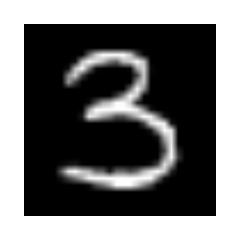

In [5]:
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(1,1,1,1)); n<-sample(42000,1)
image_example<-train_images[n,]
image_example<-array_reshape(image_example,c(28,28))
c(dim(image_example),train_labels[n,])
plot(as.raster(image_example))

In [6]:
train_indices<-1:round(.8*n)
valid_indices<-(round(.8*n)+1):round(.9*n)
test_indices<-(round(.9*n)+1):n
x_train<-train_images[train_indices,]
y_train<-train_labels[train_indices,]
x_valid<-train_images[valid_indices,]
y_valid<-train_labels[valid_indices,]
x_test<-train_images[test_indices,]
y_test<-train_labels[test_indices,]
c(dim(x_train),dim(x_valid),dim(x_test),
  dim(y_train),dim(y_valid),dim(y_test))

[1] 31843   784  3981   784  3980   784 31843    10  3981    10  3980    10

<h1 class='font-effect-3d' style='font-family:Akronim; color:#66FF66;'>Neural Network Models</h1>

In [7]:
mlp_model<-keras_model_sequential()
mlp_model %>%  
layer_dense(1568,input_shape=c(784)) %>%  
layer_activation("relu") %>%  
layer_dropout(.2) %>% 
layer_dense(392) %>%  
layer_activation("relu") %>%  
layer_dropout(.2) %>%
layer_dense(128) %>%  
layer_activation("relu") %>%  
layer_dropout(.2) %>%
layer_dense(10) %>%    
layer_activation("softmax")
mlp_model %>%
    compile(loss="categorical_crossentropy",
            optimizer="nadam",metrics="accuracy")

In [8]:
cb<-list(callback_model_checkpoint(fw,save_best_only=T),
         callback_reduce_lr_on_plateau(monitor="val_loss",factor=.75))
mlp_fit<-mlp_model %>%
    fit(x=x_train,y=y_train,callbacks=cb,
        validation_data=list(x_valid,y_valid),
        shuffle=T,batch_size=128,epochs=50)

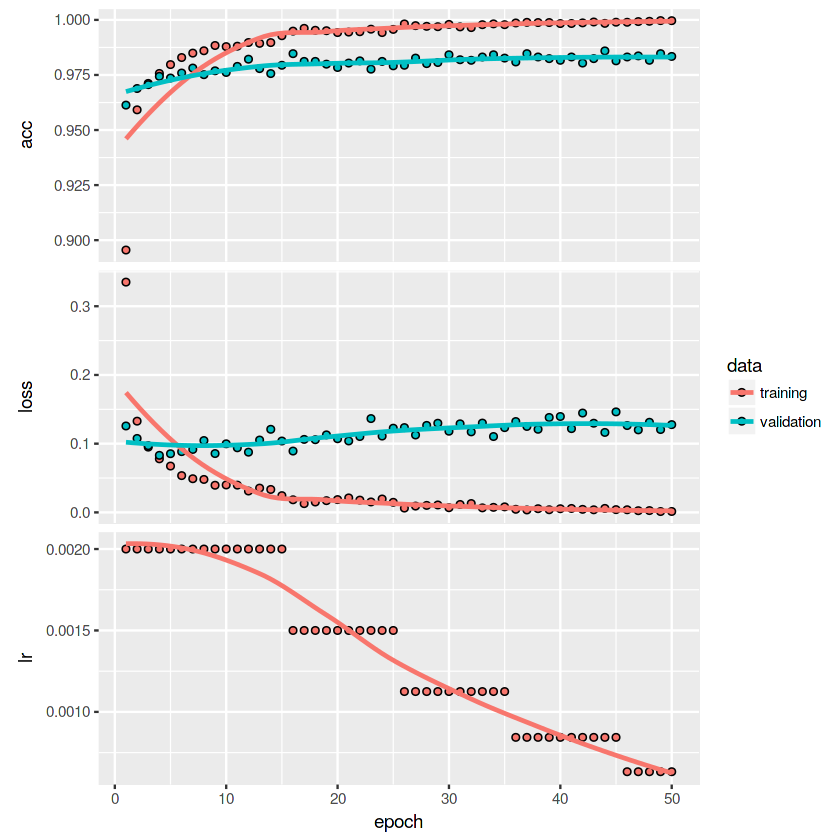

In [9]:
options(warn=-1,repr.plot.width=7,repr.plot.height=7)
plot(mlp_fit)

In [10]:
mlp_fit_df<-as.data.frame(mlp_fit)
mlp_fit_df[121:150,]

,epoch,value,metric,data
121,21,0.9804069,acc,validation
122,22,0.9814117,acc,validation
123,23,0.9776438,acc,validation
124,24,0.9811605,acc,validation
125,25,0.9791510,acc,validation
126,26,0.9794022,acc,validation
127,27,0.9826677,acc,validation
128,28,0.9801557,acc,validation
129,29,0.9806581,acc,validation
130,30,0.9841748,acc,validation


In [11]:
load_model_weights_hdf5(mlp_model,fw)
mlp_model %>% 
    evaluate(x_test,y_test)

$loss
[1] 0.08869413

$acc
[1] 0.9738693

In [12]:
rnn_model<-keras_model_sequential()
rnn_model %>%  
layer_lstm(196,return_sequences=T,
           input_shape=c(1,784)) %>%  
layer_lstm(196,return_sequences=T) %>%
layer_lstm(784) %>%  
layer_dense(10) %>%    
layer_activation("softmax")
rnn_model %>%
    compile(loss="categorical_crossentropy",
            optimizer="nadam",metrics="accuracy")

In [13]:
xt<-array_reshape(x_train,c(dim(x_train)[1],1,784))
xv<-array_reshape(x_valid,c(dim(x_valid)[1],1,784))
cb<-list(callback_model_checkpoint(fw,save_best_only=T),
         callback_reduce_lr_on_plateau(monitor="val_loss",factor=.75))
rnn_fit<-rnn_model %>%
    fit(x=xt,y=y_train,shuffle=T,batch_size=128,epochs=50,
        validation_data=list(xv,y_valid),callbacks=cb)

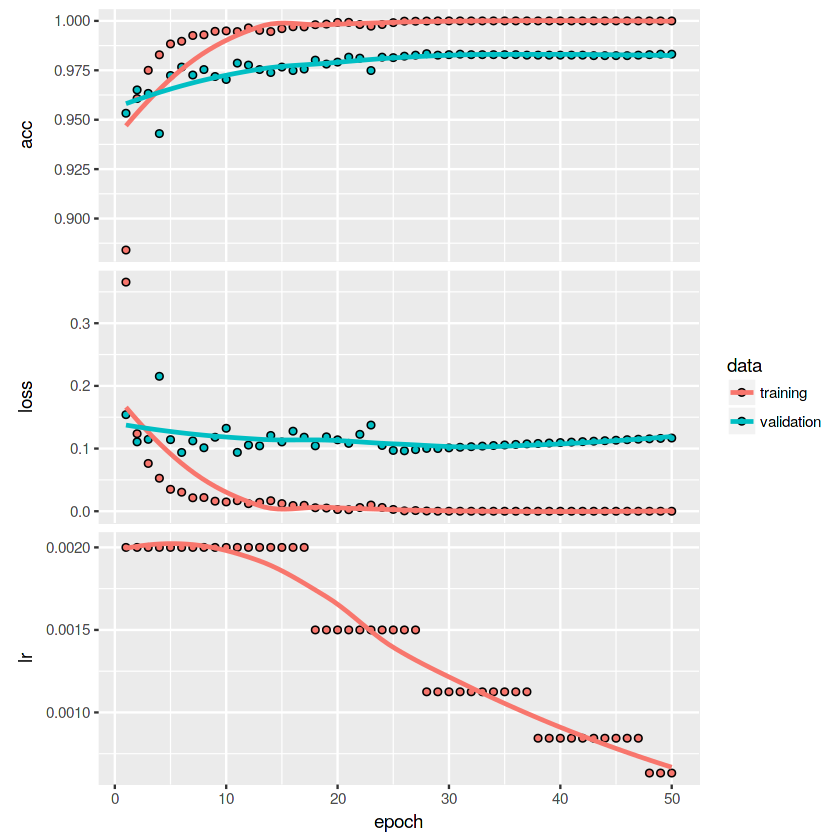

In [14]:
options(warn=-1,repr.plot.width=7,repr.plot.height=7)
plot(rnn_fit)

In [15]:
rnn_fit_df<-as.data.frame(rnn_fit)
rnn_fit_df[121:50,1:4]

,epoch,value,metric,data
121,21,9.816629e-01,acc,validation
120,20,9.791510e-01,acc,validation
119,19,9.781462e-01,acc,validation
118,18,9.801557e-01,acc,validation
117,17,9.756343e-01,acc,validation
116,16,9.748807e-01,acc,validation
115,15,9.766390e-01,acc,validation
114,14,9.738759e-01,acc,validation
113,13,9.753831e-01,acc,validation
112,12,9.776438e-01,acc,validation


In [16]:
load_model_weights_hdf5(rnn_model,fw)
rnn_model %>% 
    evaluate(array_reshape(x_test,c(dim(x_test)[1],1,784)),y_test)

$loss
[1] 0.08606202

$acc
[1] 0.9771357